In [5]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-12-08 05:39:19--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M   197KB/s    in 16s     

2022-12-08 05:39:36 (205 KB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [92]:
import numpy as np
import pandas as pd
import seaborn as sn 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

import nltk 
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import string

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [3]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [6]:
df = pd.read_csv("AirlineTweets.csv")

In [7]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
df = df[["airline_sentiment", "text"]]

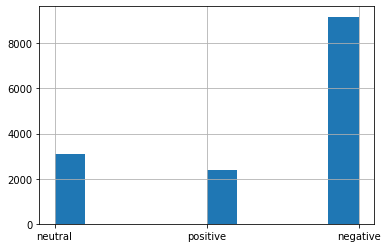

In [10]:
df["airline_sentiment"].hist();

In [12]:
df = df[df["airline_sentiment"] != "neutral"].copy()

In [13]:
target_map = {"positive": 1, "negative": 0}
df["target"] = df["airline_sentiment"].map(target_map)

In [14]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [15]:
df_train, df_test = train_test_split(df, random_state=1234)

In [63]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [93]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
    self.stopwords = set(stopwords.words("english"))
  def __call__(self, doc):
    doc = doc.rstrip().lower()
    if doc:
      doc = doc.translate(str.maketrans('', '', string.punctuation))
      tokens = word_tokenize(doc)
      words_and_tags = nltk.pos_tag(tokens)
      tokens = [t for t in tokens if len(t) > 2]
      tokens = [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]
      tokens = [t for t in tokens if t not in self.stopwords]
      tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
      return tokens

In [94]:
vectorizer = TfidfVectorizer(max_features=2000, tokenizer=LemmaTokenizer())
Xtrain = vectorizer.fit_transform(df_train["text"])
Xtest = vectorizer.transform(df_test["text"])

In [95]:
# data must not be sparse before passing into tensorflow
Xtrain = Xtrain.toarray()
Xtest = Xtest.toarray()

In [96]:
Ytrain = df_train["target"]
Ytest = df_test["target"]

In [97]:
D = Xtrain.shape[1]

In [101]:
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss
model = Model(i, x)

In [102]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

ft = model.fit(
    Xtrain, Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=30,
    batch_size=128
)

Epoch 1/30
68/68 [==============================] - 1s 5ms/step - loss: 0.5178 - accuracy: 0.7950 - val_loss: 0.4200 - val_accuracy: 0.7959
Epoch 2/30
68/68 [==============================] - 0s 3ms/step - loss: 0.3816 - accuracy: 0.7984 - val_loss: 0.3598 - val_accuracy: 0.8056
Epoch 3/30
68/68 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8142 - val_loss: 0.3227 - val_accuracy: 0.8250
Epoch 4/30
68/68 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.8389 - val_loss: 0.2968 - val_accuracy: 0.8455
Epoch 5/30
68/68 [==============================] - 0s 3ms/step - loss: 0.2634 - accuracy: 0.8578 - val_loss: 0.2781 - val_accuracy: 0.8631
Epoch 6/30
68/68 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.8778 - val_loss: 0.2638 - val_accuracy: 0.8711
Epoch 7/30
68/68 [==============================] - 0s 3ms/step - loss: 0.2261 - accuracy: 0.8878 - val_loss: 0.2533 - val_accuracy: 0.8794
Epoch 8/30
68/68 [==

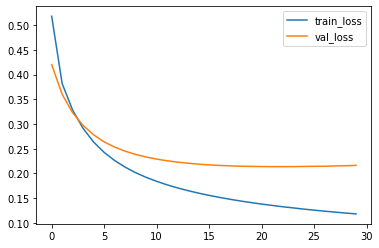

In [104]:
plt.plot(ft.history["loss"], label="train_loss")
plt.plot(ft.history["val_loss"], label="val_loss")
plt.legend();

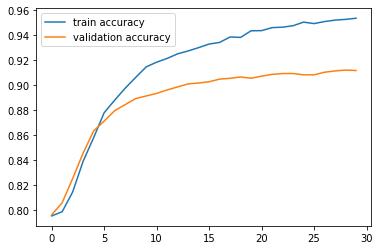

In [105]:
plt.plot(ft.history["accuracy"], label="train accuracy")
plt.plot(ft.history["val_accuracy"], label="validation accuracy")
plt.legend();

In [106]:
Ptrain = ((model.predict(Xtrain) > 0) * 1.0).flatten()
Ptest = ((model.predict(Xtest) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 1ms/step


In [107]:
cm = confusion_matrix(Ytrain, Ptrain, normalize="true")
cm

array([[0.98590321, 0.01409679],
       [0.13866967, 0.86133033]])

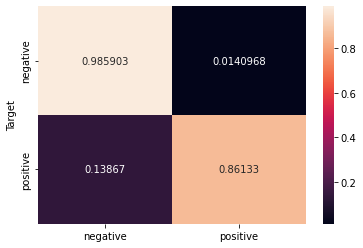

In [108]:
def plot_cm(cm):
  classes = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt="g")
  ax.set_label("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [109]:
cm_test = confusion_matrix(Ytest, Ptest, normalize="true")
cm_test

array([[0.96778407, 0.03221593],
       [0.2852292 , 0.7147708 ]])

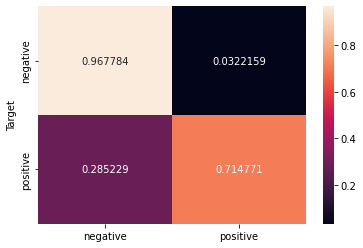

In [110]:
plot_cm(cm_test)

In [111]:
Prtrain = model.predict(Xtrain)
Prtest = model.predict(Xtest)
print(f"Train AUC: {roc_auc_score(Ytrain, Prtrain)}")
print(f"Test AUC: {roc_auc_score(Ytest, Prtest)}")

91/91 [==============================] - 0s 1ms/step
Train AUC: 0.9912141860165247
Test AUC: 0.9483706879793753


In [112]:
print(f"Train F1: {f1_score(Ytrain, Ptrain)}")
print(f"Test F1: {f1_score(Ytest, Ptest)}")

Train F1: 0.8990879670491322
Test F1: 0.7767527675276753


In [113]:
model.layers

In [114]:
model.layers[1].get_weights()

[array([[-0.7678792],
        [-2.0558445],
        [ 2.2720997],
        ...,
        [-2.5687752],
        [-2.7182603],
        [ 0.5613659]], dtype=float32), array([-0.6342282], dtype=float32)]

In [115]:
w = model.layers[1].get_weights()[0]
w

array([[-0.7678792],
       [-2.0558445],
       [ 2.2720997],
       ...,
       [-2.5687752],
       [-2.7182603],
       [ 0.5613659]], dtype=float32)

In [116]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'americanair': 80,
 'cancel': 266,
 'flightled': 710,
 'wifes': 1921,
 'flight': 701,
 'call': 262,
 'service': 1543,
 'wont': 1936,
 'even': 603,
 'let': 999,
 'u': 1806,
 'go': 783,
 'hour': 865,
 'southwestair': 1618,
 'offer': 1193,
 'absolutely': 5,
 'nothing': 1179,
 'trouble': 1786,
 'either': 571,
 'blame': 209,
 'tsa': 1794,
 'usairways': 1849,
 'whats': 1911,
 'point': 1315,
 'baggage': 166,
 'claim': 321,
 'ticket': 1747,
 'dont': 541,
 'scan': 1512,
 'track': 1772,
 'leave': 993,
 'ipad': 933,
 'den': 477,
 'open': 1212,
 'many': 1067,
 'memory': 1089,
 'plz': 1313,
 'help': 833,
 'get': 774,
 'back': 158,
 'tell': 1711,
 'software': 1601,
 'system': 1694,
 'busy': 251,
 'handle': 806,
 'shoe': 1559,
 'thank': 1722,
 'send': 1535,
 'detail': 494,
 'theyre': 1730,
 'pretty': 1342,
 'info': 918,
 'companion': 360,
 'pas': 1258,
 'flyer': 722,
 'airline': 56,
 'every': 608,
 'airport': 59,
 'united': 1830,
 'day': 458,
 'late': 984,
 'flightr': 713,
 'bag': 165,
 'iad': 880,


In [117]:
threshold = 2

print("Most positive words: ")
word_weight_tuples = []
for word, index in word_index_map.items():
  weight = w[index, 0]
  if weight > threshold:
    word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words: 
thank 8.021113
thanks 8.01478
awesome 6.09389
love 5.8424683
great 5.7695932
excellent 5.192906
kudos 5.1902285
amazing 4.933993
👍 4.735164
rock 4.6942363


In [118]:
print("Most negative words: ")
word_weight_tuples = []
for word, index in word_index_map.items():
  weight = w[index, 0]
  if weight < -threshold:
    word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words: 
rude -5.783601
strand -5.659532
pay -5.457806
hour -5.238437
whats -5.19147
delay -5.190242
ruin -5.037671
lose -5.029109
fail -5.011175
screw -4.9861584
